In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 30
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=100

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "tonguedetectiondataset",
    seed=400,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1649 files belonging to 6 classes.


In [4]:
class_names = dataset.class_names
class_names

['hairytonguedataset',
 'healthytonguedataset',
 'leokoplakiatonguedataset',
 'oralcancerdataset',
 'orallichensdataset',
 'oralthrushdataset']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(30, 256, 256, 3)
[0 3 2 5 1 2 4 0 5 3 0 2 4 2 4 2 0 2 3 5 5 1 3 5 0 3 2 0 2 2]


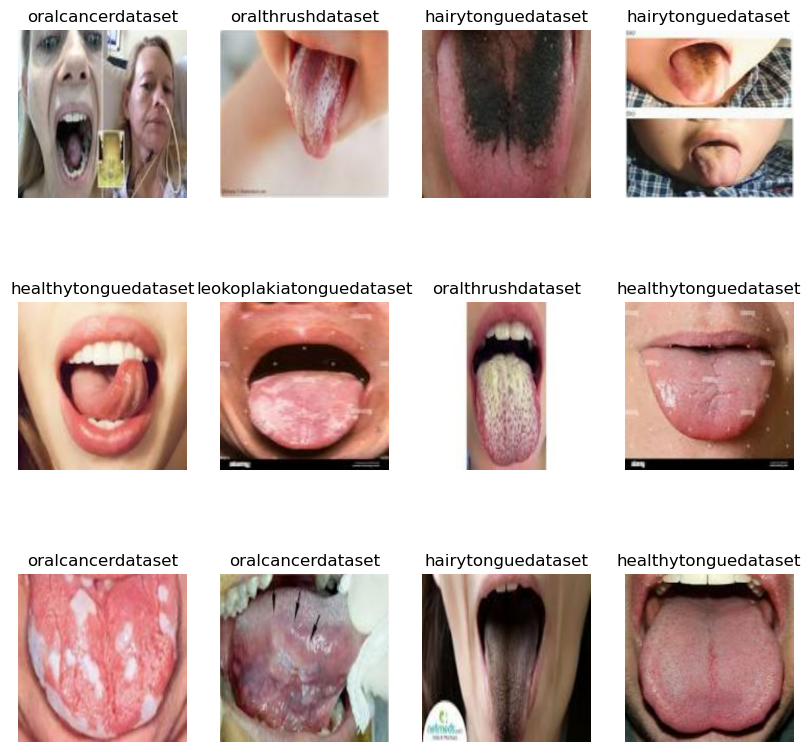

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

55

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

44

In [11]:
len(val_ds)

5

In [12]:
len(test_ds)

6

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [15]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"
                                                 ),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.3),
  ]
)

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (30, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (30, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (30, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (30, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (30, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (30, 62, 62, 64)          0         
 g2D)                                                 

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
44/44 [==============================] - 144s 3s/step - loss: 1.7845 - accuracy: 0.1926 - val_loss: 1.7720 - val_accuracy: 0.2200
Epoch 2/100
44/44 [==============================] - 128s 3s/step - loss: 1.7735 - accuracy: 0.1842 - val_loss: 1.7575 - val_accuracy: 0.1867
Epoch 3/100
44/44 [==============================] - 122s 3s/step - loss: 1.7724 - accuracy: 0.1903 - val_loss: 1.7547 - val_accuracy: 0.1867
Epoch 4/100
44/44 [==============================] - 132s 3s/step - loss: 1.7673 - accuracy: 0.2085 - val_loss: 1.7496 - val_accuracy: 0.2133
Epoch 5/100
44/44 [==============================] - 141s 3s/step - loss: 1.7451 - accuracy: 0.2403 - val_loss: 1.6181 - val_accuracy: 0.3467
Epoch 6/100
44/44 [==============================] - 136s 3s/step - loss: 1.7026 - accuracy: 0.2729 - val_loss: 1.5935 - val_accuracy: 0.3333
Epoch 7/100
44/44 [==============================] - 167s 4s/step - loss: 1.6630 - accuracy: 0.3010 - val_loss: 1.5729 - val_accuracy: 0.3400
Epoch 

44/44 [==============================] - 142s 3s/step - loss: 0.6329 - accuracy: 0.7771 - val_loss: 0.5242 - val_accuracy: 0.8667
Epoch 59/100
44/44 [==============================] - 123s 3s/step - loss: 0.6582 - accuracy: 0.7718 - val_loss: 0.5460 - val_accuracy: 0.8467
Epoch 60/100
44/44 [==============================] - 120s 3s/step - loss: 0.6513 - accuracy: 0.7748 - val_loss: 0.5585 - val_accuracy: 0.8533
Epoch 61/100
44/44 [==============================] - 139s 3s/step - loss: 0.5719 - accuracy: 0.8052 - val_loss: 0.6102 - val_accuracy: 0.7800
Epoch 62/100
44/44 [==============================] - 139s 3s/step - loss: 0.6040 - accuracy: 0.7854 - val_loss: 0.6362 - val_accuracy: 0.8200
Epoch 63/100
44/44 [==============================] - 138s 3s/step - loss: 0.6004 - accuracy: 0.7892 - val_loss: 0.4761 - val_accuracy: 0.8400
Epoch 64/100
44/44 [==============================] - 136s 3s/step - loss: 0.6120 - accuracy: 0.7839 - val_loss: 0.5230 - val_accuracy: 0.8267
Epoch 65/100

In [20]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 16s 629ms/step - loss: 0.3720 - accuracy: 0.8944


In [21]:
scores

[0.37197715044021606, 0.894444465637207]

In [22]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 44}

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']

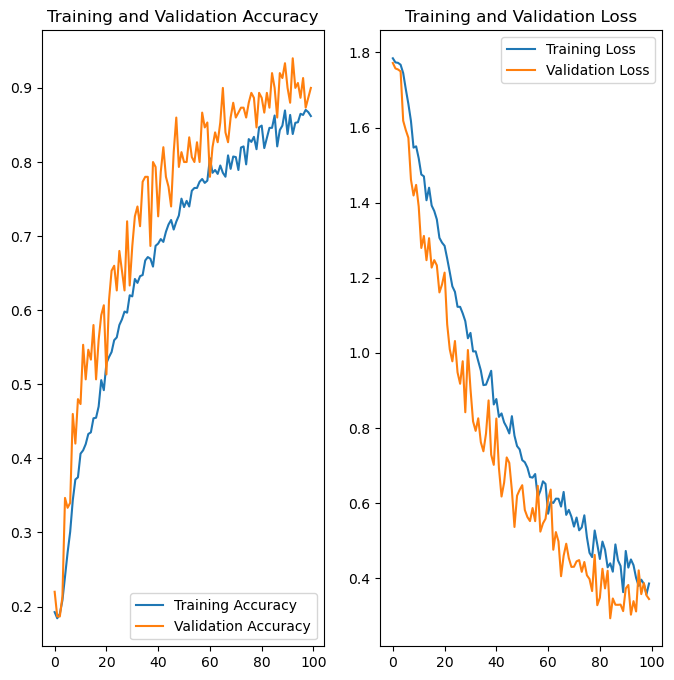

In [25]:
plt.figure(figsize= (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: orallichensdataset
1/1 [==============================] - 3s 3s/step
predicted label: orallichensdataset


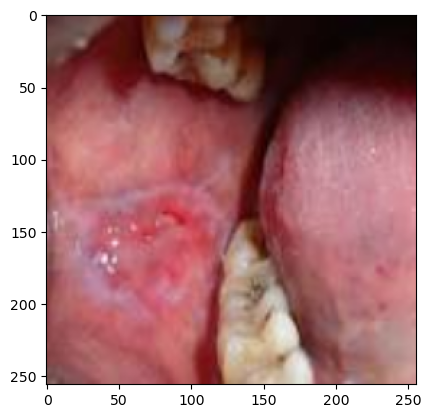

In [26]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 47ms/step


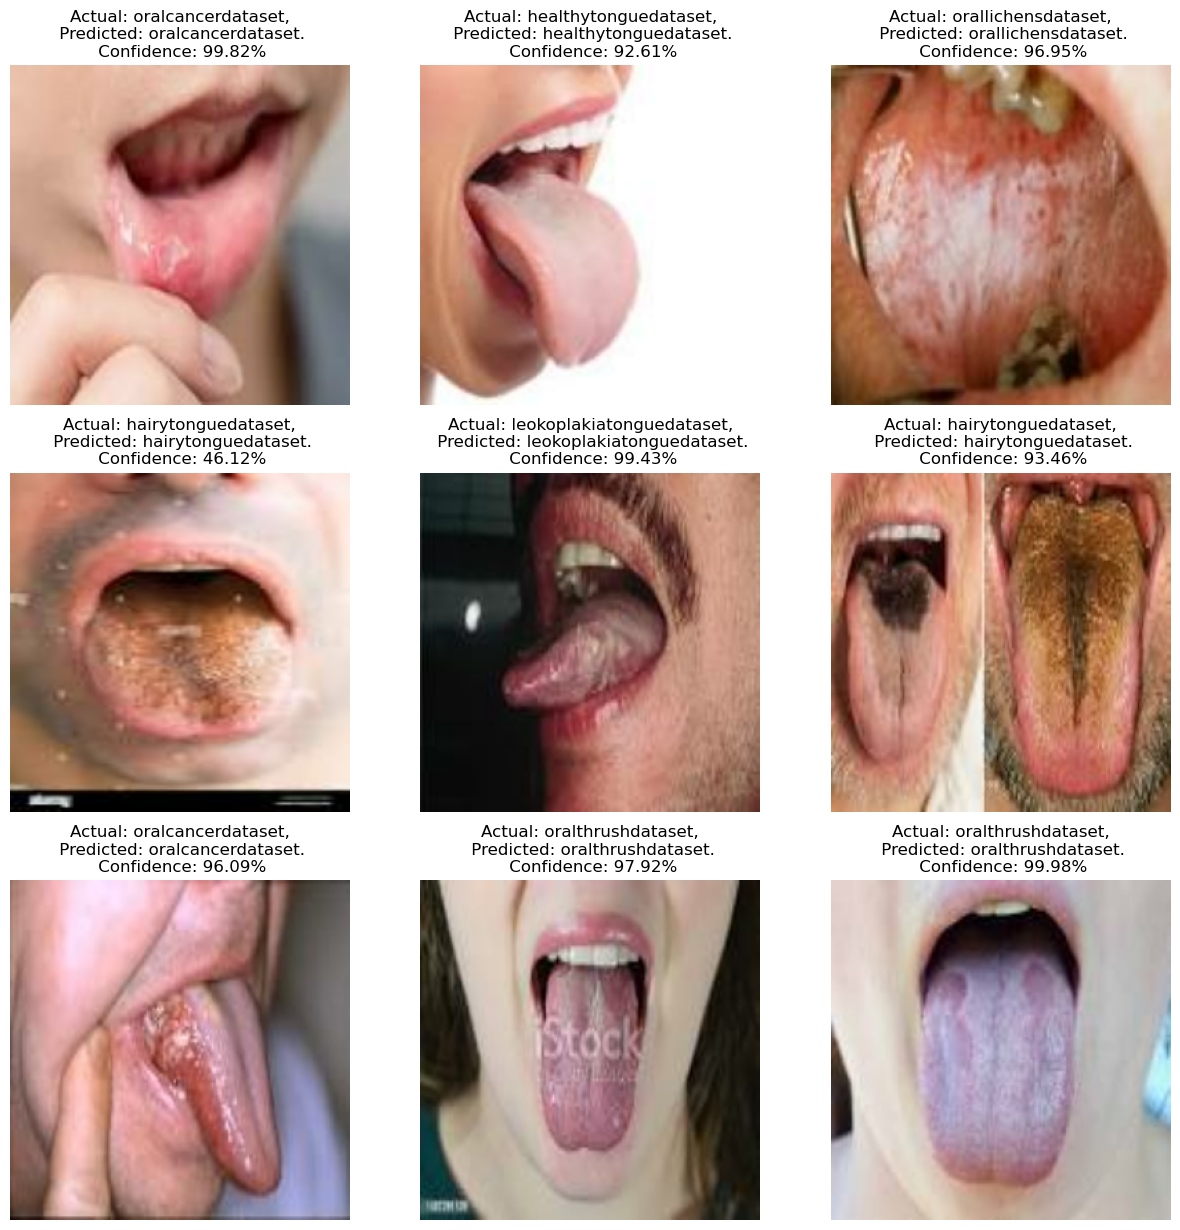

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [29]:
model_version= 2
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [30]:
model_json = model.to_json()
with open("../models/model.json", "w") as json_file:
    json_file.write(model_json)

In [31]:
model.save_weights("../models/model.h5")
print("Saved model to disk")

Saved model to disk


In [34]:
from keras.models import model_from_json
from keras.models import model_from_yaml

In [35]:
json_file = open("../models/model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [37]:
cvscores=[]
cvscores.append(scores[1]*100)


loaded_model.load_weights("../models/model.h5")
print("Loaded model from disk")
print("Accuracy after loading from disk =",np.mean(cvscores))

Loaded model from disk
Accuracy after loading from disk = 89.4444465637207
